In [1]:
import sys
import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score
from sklearn.pipeline import Pipeline

# parent directory to work with dev
sys.path.append("..")
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_card_toolkit.utils.tally_form import tally_form_to_mc
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)

## Prepare sample test dataset and fit a random forest model

In [2]:
# Credit card fraud Dataset
df = pd.read_csv("../data/fraud.csv")
x = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# # Credit risk dataset
# df = pd.read_csv("../data/credit_reject.csv")
# x = df.drop("reject", axis=1)
# y = df["reject"]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=50
)

# Model 1 - with protected attributes as model features
# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline

estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=4, max_features="sqrt", random_state = 882))])

# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)


output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)

output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas

# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)


# Model 2 - without protected attributes as model features
# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    x, y, test_size=0.87, random_state=50
)
output2 = x_test2.copy()
x_train2=x_train2.drop(['age','gender'],axis=1)
x_test2=x_test2.drop(['age','gender'],axis=1)

estimator2 = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestClassifier(n_estimators=3, max_features='sqrt', random_state = 880))])

# Fit, predict and compute performance metrics
estimator2.fit(x_train2, y_train2)


y_pred2 = estimator2.predict(x_test2)
y_probas2 = estimator2.predict_proba(x_test2)[::, 1]

precision_train2 = round(precision_score(y_train2, estimator2.predict(x_train2)),3)
recall_train2 = round(recall_score(y_train2, estimator2.predict(x_train2)), 3)
precision_test2 = round(precision_score(y_test2, y_pred2),3)
recall_test2 = round(recall_score(y_test2, y_pred2), 3)

output2["truth"] = y_test2
output2["prediction"] = y_pred2
output2["prediction_probas"] = y_probas2

# Dataframe with categorical features encoded
x_train_encoded2 = estimator2[0].transform(x_train2)
x_test_encoded2 = estimator2[0].transform(x_test2)


# Get feature importance values
df_importance2 = pd.DataFrame(
    {"features": x_test_encoded2.columns, "value": estimator2[-1].feature_importances_}
)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Get confusion matrix and ROC curve on train/test set

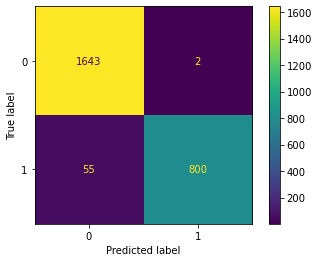

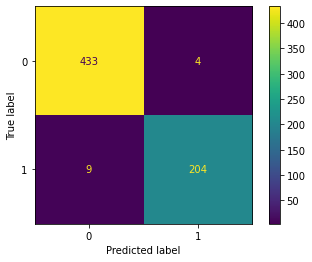

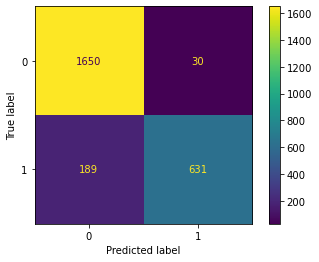

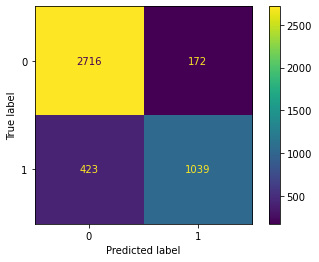

In [3]:
# Train set
# Model 1
plot_confusion_matrix(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()

# Model 2
plot_confusion_matrix(estimator2, x_train2, y_train2)
confusion_matrix_train2 = plot_to_str()

# Test set
# Model 1
plot_confusion_matrix(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()

# Model 2
plot_confusion_matrix(estimator2, x_test2, y_test2)
confusion_matrix_test2 = plot_to_str()

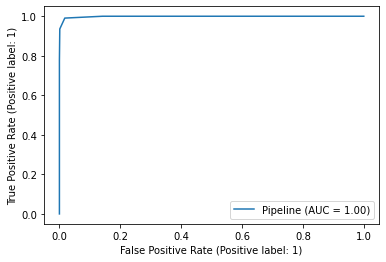

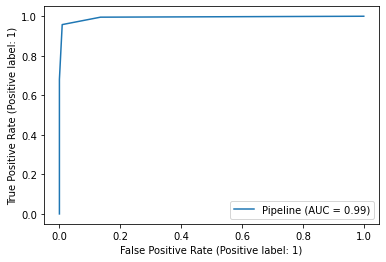

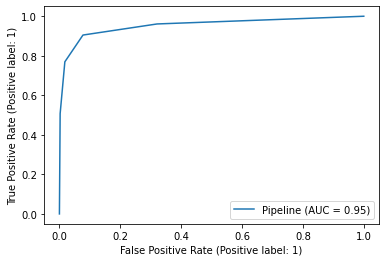

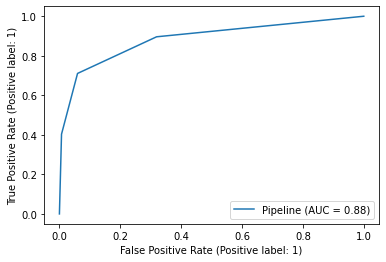

In [4]:
# Train set
# Model 1
plot_roc_curve(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Model 2
plot_roc_curve(estimator2, x_train2, y_train2)
roc_curve_train2 = plot_to_str()

# Test set
# Model 1
plot_roc_curve(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

# Model 2
plot_roc_curve(estimator2, x_test2, y_test2)
roc_curve_test2 = plot_to_str()

## Run some FEAT Tests on the data

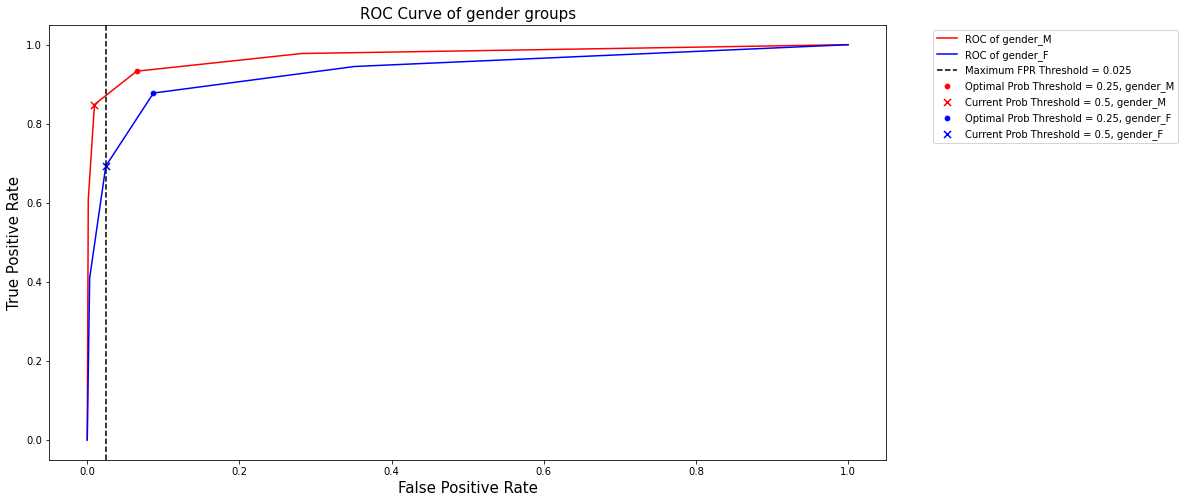

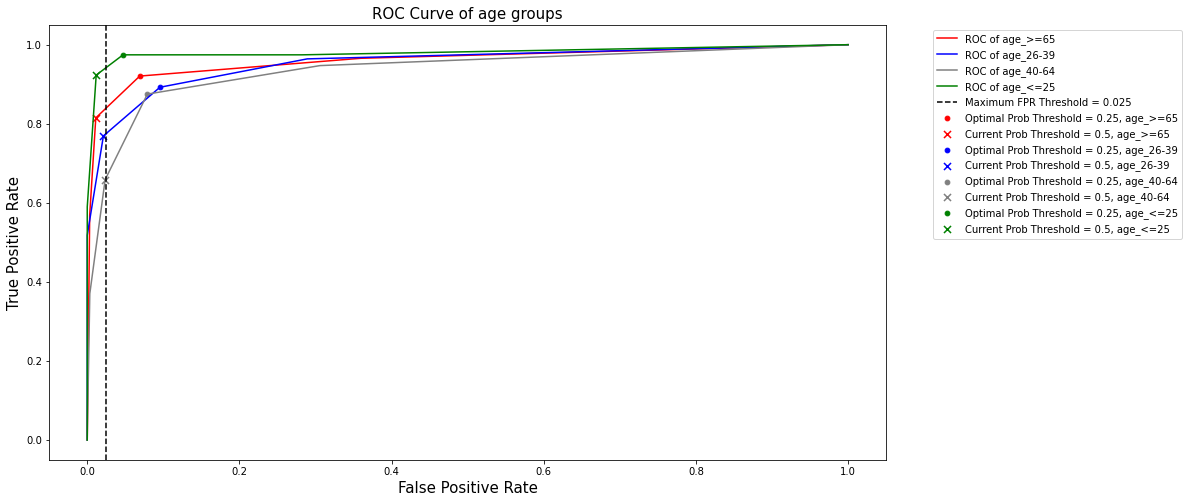

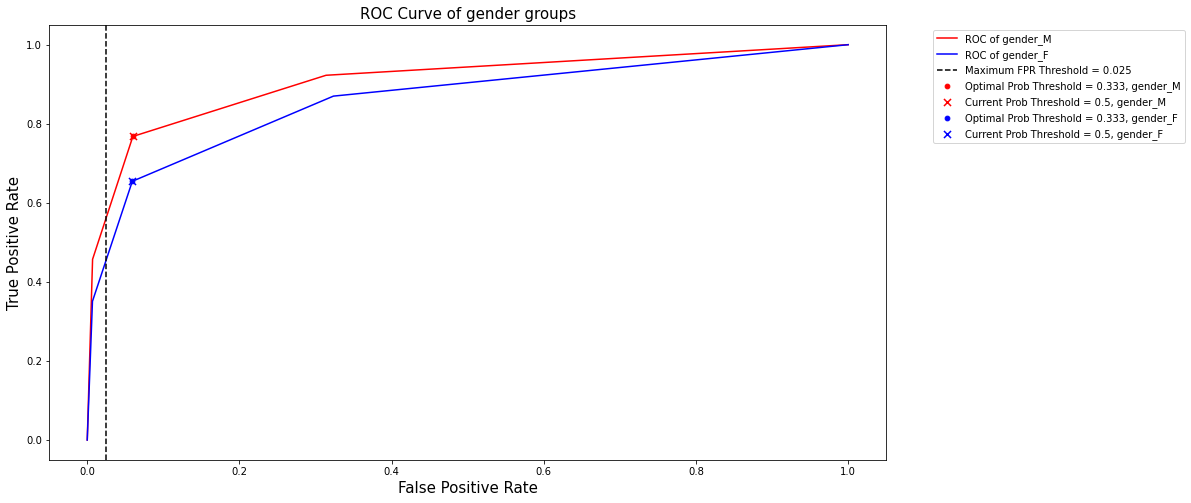

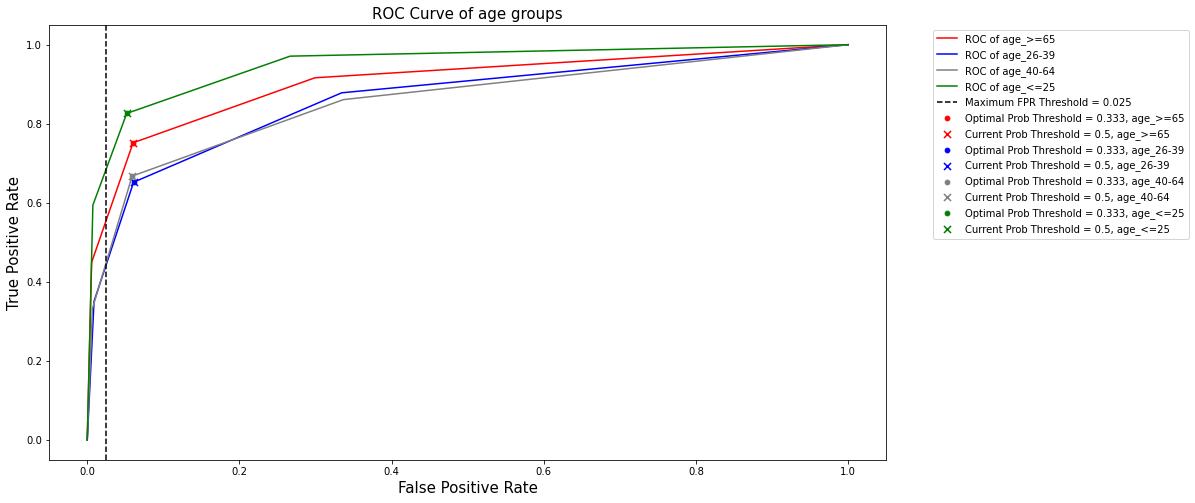

In [5]:
# ROC/Min Max Threshold Test

# Model 1
smt_test = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if blank
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.025,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

smt_test2 = MinMaxMetricThreshold(
    #test_name="",
    #test_desc="",
    attr="age",
    metric="fpr",
    threshold=0.025,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test2.run(df_test_with_output=output)
smt_test2.plot()

# Model 2
smt_test3 = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if blank
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.025,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test3.run(df_test_with_output=output2)
smt_test3.plot()

smt_test4 = MinMaxMetricThreshold(
    #test_name="",
    #test_desc="",
    attr="age",
    metric="fpr",
    threshold=0.025,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test4.run(df_test_with_output=output2)
smt_test4.plot()


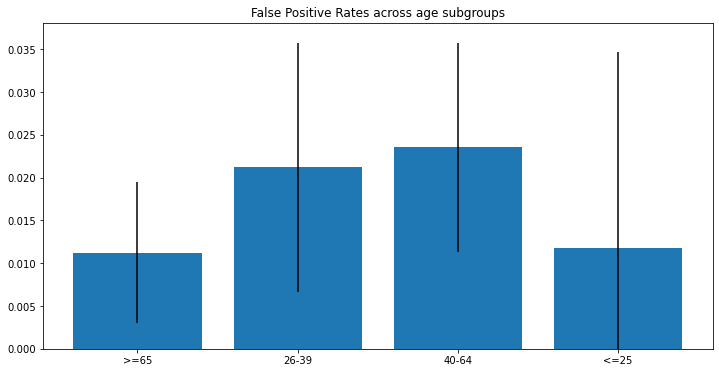

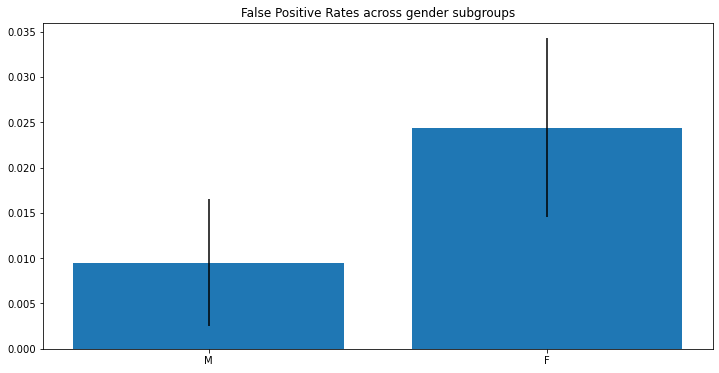

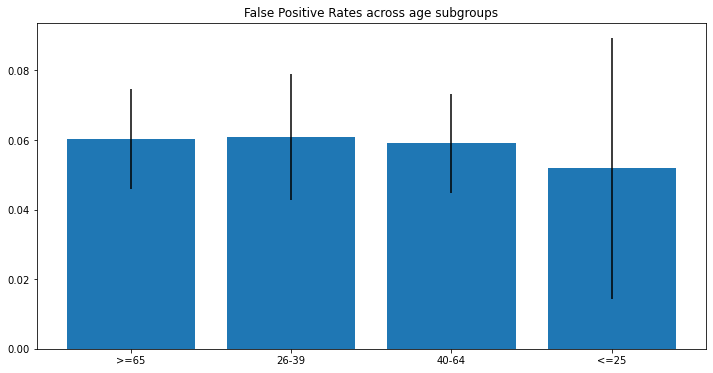

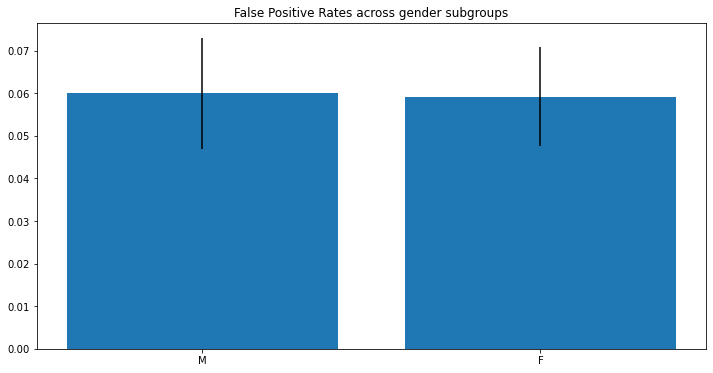

In [6]:
# Subgroup Disparity Test

# Model 1
sgd_test = SubgroupDisparity(
    #test_name="",            # Default test name and description will be used accordingly if blank
    #test_desc="",
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test.run(output)
sgd_test.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test2 = SubgroupDisparity(
    #test_name="",
    #test_desc="",
    attr='gender',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test2.run(output)
sgd_test2.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

# Model 2
sgd_test3 = SubgroupDisparity(
    #test_name="",            # Default test name and description will be used accordingly if blank
    #test_desc="",
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test3.run(output2)
sgd_test3.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test4 = SubgroupDisparity(
    #test_name="",
    #test_desc="",
    attr='gender',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)
sgd_test4.run(output2)
sgd_test4.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

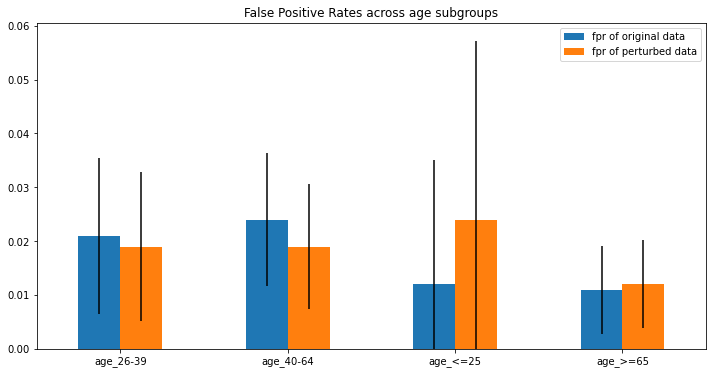

In [7]:
# Subgroup Perturbation Test

# Only applicable to Model 1
np.random.seed(123)
pmt = Perturbation(
    #test_name="",        # Default test name and description will be used accordingly if blank
    #test_desc="",
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.5,
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=estimator[0],
    model=estimator[-1]
)

pmt.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

model_output = "margin" has been renamed to model_output = "raw"


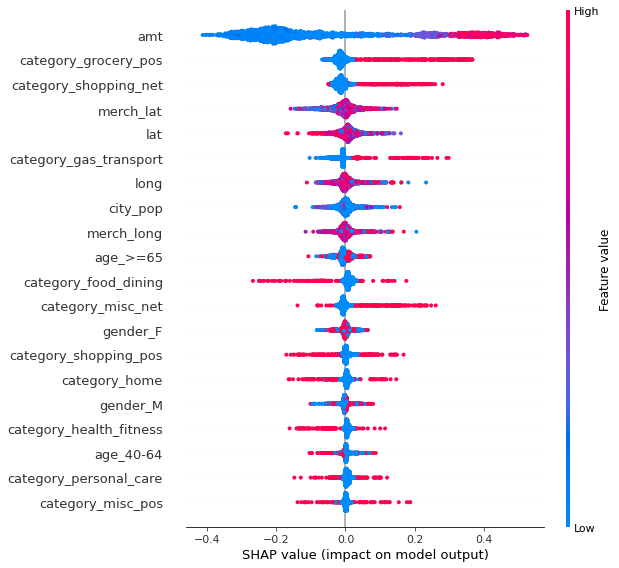

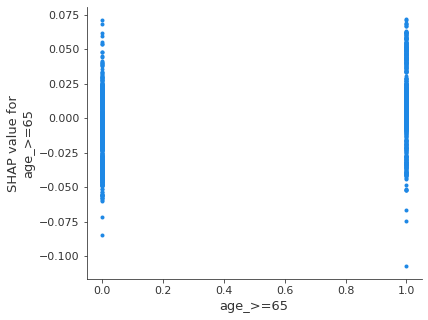

In [8]:
# Shapely Importance Features Test

# Only applicable to Model 1
shap_test = SHAPFeatureImportance(
    #test_name="",                 # Default test name and description will be used accordingly if blank
    #test_desc="",
    attrs=['gender','age'],
    threshold=10
)

shap_test.run(
    model=estimator[-1],
    model_type='trees',
    x_train_encoded=x_train_encoded,
    x_test_encoded=x_test_encoded,
)
shap_test.shap_summary_plot(x_test_encoded)
shap_test.shap_dependence_plot(x_test_encoded, show_all=False) # Show only dependence plots of attributes that failed the test


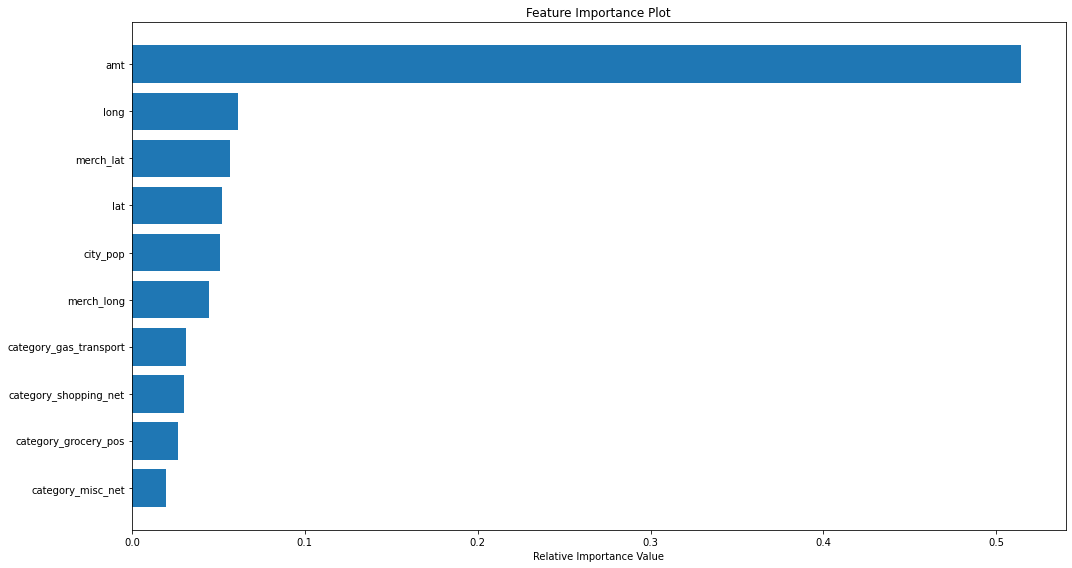

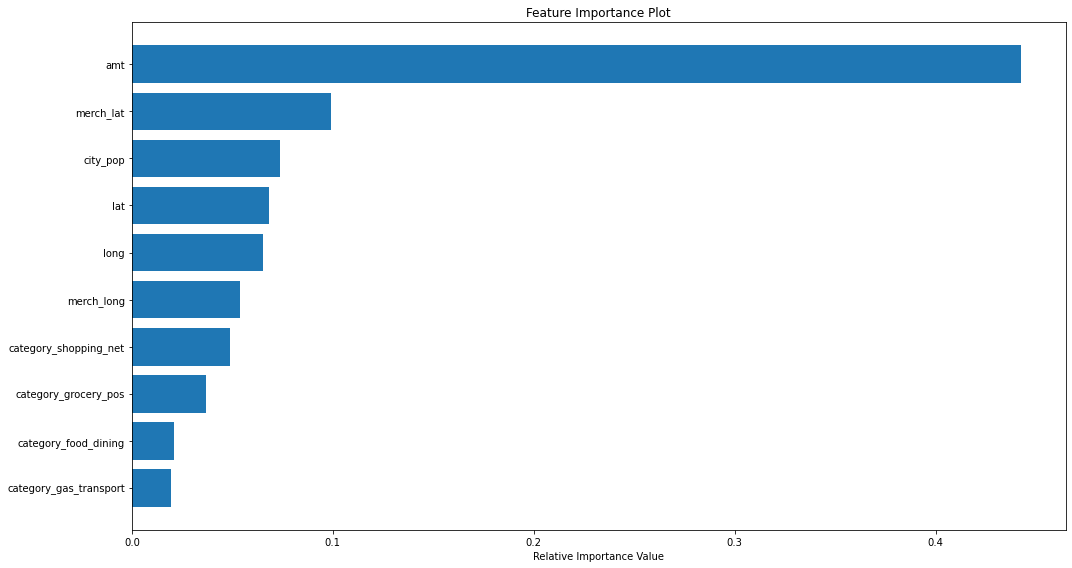

In [9]:
# User inputted Feature importance test

# Model 1
imp_test = FeatureImportance(
    #test_name="",           # Default test name and description will be used accordingly if blank
    #test_desc="",
    attrs=['gender','age'],
    threshold=10
)

imp_test.run(df_importance)
imp_test.plot(df_importance, show_n=10)   # Show top 10 most important features

# Model 2
imp_test2 = FeatureImportance(
    #test_name="",           # Default test name and description will be used accordingly if blank
    #test_desc="",
    attrs=[""],
    threshold=10
)

imp_test2.run(df_importance2)
imp_test2.plot(df_importance2, show_n=10)   # Show top 10 most important features

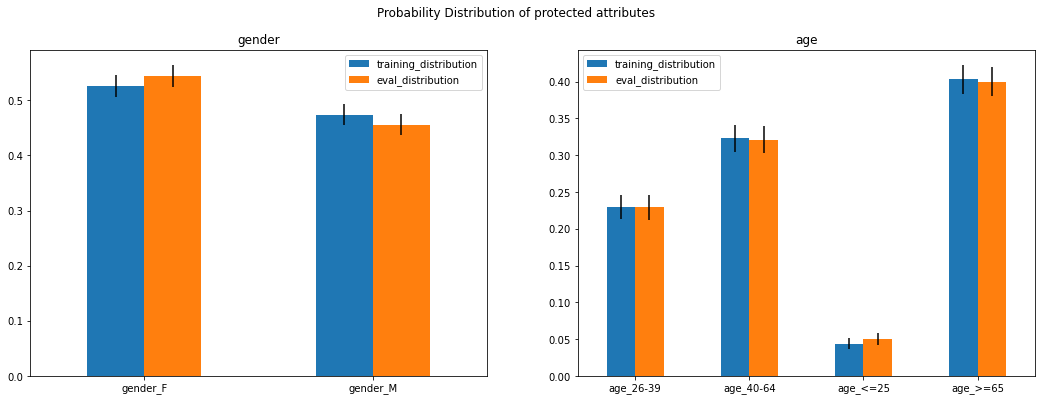

In [10]:
# Data distribution Shift Test

# Only applicable to Model 1
shift_test = DataShift(
    #test_name="",             # Default test name and description will be used accordingly if blank
    #test_desc="",
    protected_attr = ['gender','age'],
    method = 'chi2',
    threshold = 0.05
)

shift_test.run(x_train = x_train, x_test = x_test)
shift_test.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands


## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response. This is meant only as an example - the dataset and risk evaluation in the model card is a fictional use case.

In [11]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response.json")

# Initialize the mct and scaffold using the existing protobuf, for model 1
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="credit_card_fraud_example")
mc = mct.scaffold_assets(proto=pb)

# Initialize the mct and scaffold using the existing protobuf, for model 2
mct2 = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="credit_card_fraud_example2")
mc2 = mct2.scaffold_assets(proto=pb)

## Convert test objects to a model-card-compatible format

In [12]:
# Model 1

# init model card test objects
mc_smt_test = mctlib.Test()
mc_smt_test2 = mctlib.Test()
mc_sgd_test = mctlib.Test()
mc_sgd_test2 = mctlib.Test()
mc_pmt_test = mctlib.Test()
mc_shap_test = mctlib.Test()
mc_imp_test = mctlib.Test()
mc_shift_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_smt_test2.read_model_test(smt_test2)
mc_sgd_test.read_model_test(sgd_test)
mc_sgd_test2.read_model_test(sgd_test2)
mc_pmt_test.read_model_test(pmt)
mc_imp_test.read_model_test(imp_test)
mc_shap_test.read_model_test(shap_test)
mc_shift_test.read_model_test(shift_test)


# Model 2

# init model card test objects
mc_smt_test3 = mctlib.Test()
mc_smt_test4 = mctlib.Test()
mc_sgd_test3 = mctlib.Test()
mc_sgd_test4 = mctlib.Test()
mc_imp_test2 = mctlib.Test()

# assign tests to them
mc_smt_test3.read_model_test(smt_test3)
mc_smt_test4.read_model_test(smt_test4)
mc_sgd_test3.read_model_test(sgd_test3)
mc_sgd_test4.read_model_test(sgd_test4)
mc_imp_test2.read_model_test(imp_test2)

In [13]:
# Add quantitative analysis

# Model 1
### Create 4 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 4)]
mc.quantitative_analysis.performance_metrics[0].type = "Recall"
mc.quantitative_analysis.performance_metrics[0].value = str(recall_train)
mc.quantitative_analysis.performance_metrics[0].slice = "Training Set"

mc.quantitative_analysis.performance_metrics[1].type = "Precision"
mc.quantitative_analysis.performance_metrics[1].value = str(precision_train)
mc.quantitative_analysis.performance_metrics[1].slice = "Training Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_train), mctlib.Graphic(image=roc_curve_train)
]

mc.quantitative_analysis.performance_metrics[2].type = "Recall"
mc.quantitative_analysis.performance_metrics[2].value = str(recall_test)
mc.quantitative_analysis.performance_metrics[2].slice = "Test Set"

mc.quantitative_analysis.performance_metrics[3].type = "Precision"
mc.quantitative_analysis.performance_metrics[3].value = str(precision_test)
mc.quantitative_analysis.performance_metrics[3].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[3].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[3].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_test), mctlib.Graphic(image=roc_curve_test)
]

# Model 2
### Create 4 PerformanceMetric to store our results
mc2.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 4)]
mc2.quantitative_analysis.performance_metrics[0].type = "Recall"
mc2.quantitative_analysis.performance_metrics[0].value = str(recall_train2)
mc2.quantitative_analysis.performance_metrics[0].slice = "Training Set"

mc2.quantitative_analysis.performance_metrics[1].type = "Precision"
mc2.quantitative_analysis.performance_metrics[1].value = str(precision_train2)
mc2.quantitative_analysis.performance_metrics[1].slice = "Training Set"
mc2.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Confusion matrix and ROC Curve')
mc2.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_train2), mctlib.Graphic(image=roc_curve_train2)
]

mc2.quantitative_analysis.performance_metrics[2].type = "Recall"
mc2.quantitative_analysis.performance_metrics[2].value = str(recall_test2)
mc2.quantitative_analysis.performance_metrics[2].slice = "Test Set"

mc2.quantitative_analysis.performance_metrics[3].type = "Precision"
mc2.quantitative_analysis.performance_metrics[3].value = str(precision_test2)
mc2.quantitative_analysis.performance_metrics[3].slice = "Test Set"
mc2.quantitative_analysis.performance_metrics[3].graphics.description = (
  'Confusion matrix and ROC Curve')
mc2.quantitative_analysis.performance_metrics[3].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_test2), mctlib.Graphic(image=roc_curve_test2)
]

In [14]:
# You can add the components of a test (e.g. on explainability) in a report

# Model 1
mc.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Top 10 most important features", graphics=mctlib.GraphicsCollection(
            collection = [mctlib.Graphic(name=n, image=i) for n, i in imp_test.plots.items()]
        )
    )
]

# Or you can add it as a test directly
mc.explainability_analysis.explainability_reports.append(
    mctlib.ExplainabilityReport(type="Protected Attributes should not be model's top important features", tests=[mc_shap_test])
)

# Model 2
mc2.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Top 10 most important features", graphics=mctlib.GraphicsCollection(
            collection = [mctlib.Graphic(name=n, image=i) for n, i in imp_test2.plots.items()]
        )
    )
]


In [15]:
# Model 1

# The bootstrap template comes with two requirements on fairness analysis:
# Minimum acceptable service and Equal false positive rate
# We add the relevant tests associated with it
mc.fairness_analysis.fairness_reports[0].tests = [mc_smt_test,mc_smt_test2]
mc.fairness_analysis.fairness_reports[1].tests = [mc_sgd_test,mc_sgd_test2]

# We also add a test for attribute shift between the training and testing dataset for additional reliablity check
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type="Distribution of attribute subgroups should be silimiar across different datasets", tests=[mc_shift_test])
)
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type='Fairness metric for subgroups in original data and perturbed data should be similar', tests=[mc_pmt_test])
)

mct.update_model_card(mc)

# Model 2

# The bootstrap template comes with two requirements on fairness analysis:
# Minimum acceptable service and Equal false positive rate
# We add the relevant tests associated with it
mc2.fairness_analysis.fairness_reports[0].tests = [mc_smt_test3,mc_smt_test4]
mc2.fairness_analysis.fairness_reports[1].tests = [mc_sgd_test3,mc_sgd_test4]


mct2.update_model_card(mc2)

## Model Card Display

In [16]:
# Model 1
# Export to html
html = mct.export_format(output_file="credit_card_fraud_example.html")

display.display(display.HTML(html))

,feature_rank,passed
age_>=65,10.0,False
gender_F,13.0,True
gender_M,16.0,True
age_40-64,18.0,True
age_26-39,21.0,True
age_<=25,26.0,True
,fpr at current probability threshold,passed
gender_M,0.009,True
gender_F,0.024,True


In [17]:
# Model 2
# Export to html
mc2.model_details.name = "Credit Card Fraud Model, without protected attributes as model features"
html2 = mct2.export_format(output_file="credit_card_fraud_example2.html")

display.display(display.HTML(html2))

,fpr at current probability threshold,passed
gender_M,0.06,False
gender_F,0.059,False
,fpr at current probability threshold,passed
age_>=65,0.06,False
age_26-39,0.061,False
age_40-64,0.059,False
age_<=25,0.052,False


In [18]:
# Compare the score cards (on the same content) between model1 and model2
html_compare=mct.compare_model_cards(mc, mc2, export_path='model_card_output/model_cards/credit_card_fraud_comparision.html')
display.display(display.HTML(html_compare))

,age_fpr_max_ratio
0,2.094
,gender_fpr_max_ratio
0,2.574
,age_fpr_max_ratio
0,1.175
,gender_fpr_max_ratio
0,1.013
